The below notebook features the generation of sentiment scores and features along with LDA topic modeling.

## Import Libraries

In [ ]:
%%capture
#Standard
import pandas as pd
import numpy as np
import statsmodels.api as sm

#Gensim for LDA
!pip install gensim
import gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#For visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from collections import defaultdict
from datetime import date, datetime

#NRCLex and nltk for preprocessing and sentiment analysis
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, opinion_lexicon

#Vectorizer with sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
!pip install plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
!pip install pyLDAvis
import pyLDAvis

#Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


#Define functions
def get_ngrams(gram_name, corpus, ngram_range):
  vectorizer = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(ngram_range))
  cv_matrix = vectorizer.fit_transform(corpus)
  sparse = pd.DataFrame.sparse.from_spmatrix(cv_matrix, columns=vectorizer.get_feature_names())
  sums = sparse.sum(axis=0)
  sums = sums.sort_values(axis=0, ascending=False)
  ngrams = sums.to_frame()
  ngrams = ngrams.reset_index()
  ngrams = ngrams.rename(columns={"index": gram_name})
  return ngrams

# Function to get text in desired lowercase form
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

# Function for different forms of tokeniztion (all 3 forms tested for performace)
def tokenize(words, modulation):
    tokens = re.split(r'\W+', words)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation==0:
                    stems.append(lowers)
    return stems

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [ ]:
# Instantiate Stemmer
porter = SnowballStemmer("english")

# Instantiate Lemmetizer
lmtzr = WordNetLemmatizer()

# Set Stropwords - Combination of generic english stopwords and list of words noticed to be too generic when viewing bigram and
# trigram outputs during vectorization
stop_words = set(stopwords.words('english'))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Text_Mining/Advanced Topics/archive.zip (Unzipped Files)/bbc_news.csv")

## Import Data

In [ ]:
#Create corpus featuring title and description
df['corpus'] = df['title'] + ' ' + df['description']

#Get datetime
df['pubDate'] = pd.to_datetime(df['pubDate'])
df['date'] = df['pubDate'].dt.date
df.sort_values(by='date', ignore_index=True, inplace=True)

#Eliminate first 3 rows which were erroneously included from years prior
df = df[3:]

## Sentiment Analysis

### NRCLex

In [ ]:
txtday = df.groupby(['date'])['corpus'].apply(lambda x: ','.join(x)).reset_index()
#To get daily aggregates
df_daily = df.groupby(by=['date']).sum()
df_daily['corpus'] = txtday['corpus'].values

NRC_emotion_list = []

for i in df_daily['corpus']:
  emotion = NRCLex(i)
  NRC_emotion_list.append(emotion.affect_frequencies)


nrc_df = pd.DataFrame(NRC_emotion_list)

#Create rolling averages of emotions for visualization purposes
columns = ['Positive', 'Negative' , 'Trust' , 'Fear', 'Anticipation', 'Anger', 'Joy', 'Sadness', 'Surprise','Disgust']
for emotion in nrc_df:
    nrc_df[emotion+"Rolling Average"] = nrc_df[emotion].rolling(5).mean()
#Reorder columns for plotting
columns = ['positive_rollingavg', 'negative_rollingavg' , 'trust_rollingavg' , 'fear_rollingavg', 'anticipation_rollingavg', 'anger_rollingavg', 'joy_rollingavg', 'sadness_rollingavg', 'surprise_rollingavg','disgust_rollingavg']
cols = nrc_df.iloc[:,-10:-1].columns

nrc_df.drop(columns='anticip', axis=1, inplace=True)

nrc_df.rename(columns = {'fearRolling Average' : 'Fear',
       'angerRolling Average' : 'Anger', 'anticipRolling Average' : 'Anticipation',
       'trustRolling Average' : 'Trust', 'surpriseRolling Average' :'Surprise',
       'positiveRolling Average' :'Positive', 'negativeRolling Average' :'Negative',
       'sadnessRolling Average' :'Sadness', 'disgustRolling Average' :'Disgust',
       'joyRolling Average' :'Joy', 'anticipationRolling Average' :'Anticipation 2'}, inplace=True)

#Take only last 10 columns and drop the last one (duplicate of anticipation)
cols = nrc_df.iloc[:,-10:].columns

fig = px.line(nrc_df, x=df_daily.index, y=cols,
             # hover_data={"Date"},
              title='BBC Daily Emotion Scores - Classified by NRC - 5 Day Rolling Average'
              )
fig.update_xaxes(rangeslider_visible=True,
    #dtick="M1",
    tickformat="%b\n%d")
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="NRC Emotion Score", xaxis_title="Date")
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  This is separate from the ipykernel package so we can avoid doing imports until


### Sentiment for Each Observation

In [ ]:
NRC_emotion_list = []

for i in df['corpus']:
  emotion = NRCLex(i)
  NRC_emotion_list.append(emotion.affect_frequencies)


nrc_df = pd.DataFrame(NRC_emotion_list)

#Create rolling averages of emotions for visualization purposes
columns = ['Positive', 'Negative' , 'Trust' , 'Fear', 'Anticipation', 'Anger', 'Joy', 'Sadness', 'Surprise','Disgust']
for emotion in nrc_df:
    nrc_df[emotion+"Rolling Average"] = nrc_df[emotion].rolling(5).mean()
#Reorder columns for plotting
columns = ['positive_rollingavg', 'negative_rollingavg' , 'trust_rollingavg' , 'fear_rollingavg', 'anticipation_rollingavg', 'anger_rollingavg', 'joy_rollingavg', 'sadness_rollingavg', 'surprise_rollingavg','disgust_rollingavg']
cols = nrc_df.iloc[:,-10:-1].columns

nrc_df.drop(columns='anticip', axis=1, inplace=True)

nrc_df.rename(columns = {'fearRolling Average' : 'Fear',
       'angerRolling Average' : 'Anger', 'anticipRolling Average' : 'Anticipation',
       'trustRolling Average' : 'Trust', 'surpriseRolling Average' :'Surprise',
       'positiveRolling Average' :'Positive', 'negativeRolling Average' :'Negative',
       'sadnessRolling Average' :'Sadness', 'disgustRolling Average' :'Disgust',
       'joyRolling Average' :'Joy', 'anticipationRolling Average' :'Anticipation 2'}, inplace=True)

#Take only last 10 columns and drop the last one (duplicate of anticipation)
cols = nrc_df.iloc[:,-10:].columns

fig = px.line(nrc_df, x=df.index, y=cols,
             # hover_data={"Date"},
              title='BBC Daily Emotion Scores - Classified by NRC'
              )
fig.update_xaxes(rangeslider_visible=True,
    #dtick="M1",
    tickformat="%b\n%d")
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="NRC Emotion Score", xaxis_title="Observation")
fig.show()

### Vader

In [ ]:
#Instantiate Vader
analyzer = SentimentIntensityAnalyzer()

df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['corpus']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['corpus']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['corpus']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['corpus']]

#### Inspect Rolling Average - 10 Observations

In [ ]:
df_v = df.copy()

for emotion in df_v.iloc[:,-3:]:
    df_v[emotion+"Rolling Average"] = df_v[emotion].rolling(10).mean()

df_v.sort_values(by='pubDate', inplace=True)
df_v.set_index("pubDate")
fig = px.line(df_v.iloc[:,-3:], x=df_v['pubDate'], y=df_v.iloc[:,-3:].columns,
             # hover_data={"Date"},
              title='VADER Sentiment Scores for BBC Article Titles - Rolling 10 Observation Average'
              )
fig.update_xaxes(rangeslider_visible=True,
    #dtick="M1",
    tickformat="%b\n%d")
#fig['layout']['xaxis']['autorange'] = "reversed"
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="VADER Sentiment Score", xaxis_title="Date")
fig.show()

#### Inspect Compound Scores

In [ ]:
df_v = df.copy()
df_v.sort_values(by='pubDate', inplace=True)
df_v.set_index("pubDate")
fig = px.line(df_v.iloc[:,-4:-3], x=df_v['pubDate'], y=df_v.iloc[:,-4:-3].columns,
             # hover_data={"Date"},
              title='VADER Compound Sentiment Scores - BBC Articles'
              )
fig.update_xaxes(rangeslider_visible=True,
    #dtick="M1",
    tickformat="%b\n%d")
#fig['layout']['xaxis']['autorange'] = "reversed"
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="VADER Compound Score", xaxis_title="Date")
fig.show()

#### Get Daily Sentiment Scores

In [ ]:
analyzer = SentimentIntensityAnalyzer()

df_daily['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df_daily['corpus']]
df_daily['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_daily['corpus']]
df_daily['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_daily['corpus']]
df_daily['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_daily['corpus']]

df_vd = df_daily.copy()
fig = px.line(df_vd.iloc[:,-4:], x=df_vd.index, y=df_vd.iloc[:,-4:].columns,
             # hover_data={"Date"},
              title='VADER Sentiment Scores - Daily Aggregated BBC Articles'
              )
fig.update_xaxes(rangeslider_visible=True,
    #dtick="M1",
    tickformat="%b\n%d")
#fig['layout']['xaxis']['autorange'] = "reversed"
fig.update_layout(legend_traceorder="normal", legend_title_text='Emotion')
fig.update_layout(yaxis_title="VADER Sentiment Score", xaxis_title="Date")
fig.show()

## N-Grams and LDA

Below we create N-Grams based on different preprocessing methods and then run the LDA

In [ ]:
words = get_ngrams(("Unigrams"), df['corpus'], (1,1))
para_text = df['corpus']
doc_text = [' '.join(df['corpus'])]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
#Lowercase
para_0 = [tokenize(paragraph, 0) for paragraph in para_text]
doc_0 = [tokenize(document, 0) for document in doc_text]

# Stemming
para_1 = [tokenize(paragraph, 1) for paragraph in para_text]
doc_1 = [tokenize(document, 1) for document in doc_text]

# Lemmatize
para_2 = [tokenize(paragraph, 2) for paragraph in para_text]
doc_2 = [tokenize(document, 2) for document in doc_text]

# Instanciate CountVectorizer (Tokenizer set to iterate over documents/paragraphs)

cv2 = CountVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, lowercase=False) # Bigrams
cv3 = CountVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, lowercase=False) # Trigrams


#Here we use various preprocessing techniques

#Lemmatizing: Verbs in past and future tenses are changed into present. 3rd person is change to 1st person. 
#Stemming: Reducing words to the root form
#The function parameters $max_df$ and $min_df$ can be  tuned to optimise results. 
#These parameters create an upper- and lower-threshold, respectively, such that terms with frequencies outside these bounds are ignored.

# Bigrams

# Get Documnet-Term Matrix
vec_para_0 = cv2.fit_transform(para_0)

# Better Visualise Output
p0 = pd.DataFrame.sparse.from_spmatrix(vec_para_0, columns=cv2.get_feature_names())
p0 = p0.sum(axis=0)
p0 = p0.sort_values(axis=0, ascending=False)
print("Lowercase Bigrams", p0.head(25))

# Trigrams (as for bigrams)

vec_para_0 = cv3.fit_transform(para_0)

p0 = pd.DataFrame.sparse.from_spmatrix(vec_para_0, columns=cv3.get_feature_names())
p0 = p0.sum(axis=0)
p0 = p0.sort_values(axis=0, ascending=False)
print("Lowercase Trigrams", p0.head(25))

# Stemming Bigrams

vec_para_1 = cv2.fit_transform(para_1)

p1 = pd.DataFrame.sparse.from_spmatrix(vec_para_1, columns=cv2.get_feature_names())
p1 = p1.sum(axis=0)
p1 = p1.sort_values(axis=0, ascending=False)
print("Stemming Bigrams", p1.head(25))

# Stemming Trigrams

vec_para_1 = cv3.fit_transform(para_1)

p1 = pd.DataFrame.sparse.from_spmatrix(vec_para_1, columns=cv3.get_feature_names())
p1 = p1.sum(axis=0)
p1 = p1.sort_values(axis=0, ascending=False)
print("Stemming Trigrams", p1.head(25))

# Lemmatizing Bigrams

vec_para_2 = cv2.fit_transform(para_2)

p2 = pd.DataFrame.sparse.from_spmatrix(vec_para_2, columns=cv2.get_feature_names())
p2 = p2.sum(axis=0)
p2 = p2.sort_values(axis=0, ascending=False)
print("Lemmatizing Bigrams", p2.head(25))

# Lemmatizing Trigrams

vec_para_3 = cv3.fit_transform(para_2)

p3 = pd.DataFrame.sparse.from_spmatrix(vec_para_3, columns=cv3.get_feature_names())
p3 = p3.sum(axis=0)
p3 = p3.sort_values(axis=0, ascending=False)
print("Lemmatizing Trigrams", p3.head(25))

# Instanciate TfidfVectorizer (tokenizer set to iterate over documents/paragraphs)

tfidf2 = TfidfVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, lowercase=False) # Bigrams
tfidf3 = TfidfVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, lowercase=False) # Trigrams

# Get Documnet-Term Matrix
tfidf_doc_0 = tfidf2.fit_transform(doc_0)

# Better Visualise Output
d0 = pd.DataFrame.sparse.from_spmatrix(tfidf_doc_0, columns=tfidf2.get_feature_names())
d0 = d0.sum(axis=0)
d0 = d0.sort_values(axis=0, ascending=False)
print("Lowercase Bigrams", d0.head(25))

# Trigrams (as for bigrams)

tfidf_doc_0 = tfidf3.fit_transform(doc_0)

d0 = pd.DataFrame.sparse.from_spmatrix(tfidf_doc_0, columns=tfidf3.get_feature_names())
d0 = d0.sum(axis=0)
d0 = d0.sort_values(axis=0, ascending=False)
print("Lowercase Trigrams", d0.head(25))

# Stemming Bigrams

tfidf_doc_1 = tfidf2.fit_transform(doc_1)

d1 = pd.DataFrame.sparse.from_spmatrix(tfidf_doc_1, columns=tfidf2.get_feature_names())
d1 = d1.sum(axis=0)
d1 = d1.sort_values(axis=0, ascending=False)
print("Stemming Bigrams", d1.head(25))

# Stemming Trigrams

tfidf_doc_1 = tfidf3.fit_transform(doc_1)

d1 = pd.DataFrame.sparse.from_spmatrix(tfidf_doc_1, columns=tfidf3.get_feature_names())
d1 = d1.sum(axis=0)
d1 = d1.sort_values(axis=0, ascending=False)
print("Stemming Trigrams", d1.head(25))

# Lemmatizing Bigrams

tfidf_doc_2 = tfidf2.fit_transform(doc_2)

d2 = pd.DataFrame.sparse.from_spmatrix(tfidf_doc_2, columns=tfidf2.get_feature_names())
d2 = d2.sum(axis=0)
d2 = d2.sort_values(axis=0, ascending=False)
print("Lemmatizing Bigrams", d2.head(25))

# Lemmatizing Trigrams

tfidf_doc_3 = tfidf3.fit_transform(doc_2)

p3 = pd.DataFrame.sparse.from_spmatrix(tfidf_doc_3, columns=tfidf3.get_feature_names())
p3 = p3.sum(axis=0)
p3 = p3.sort_values(axis=0, ascending=False)
print("Lemmatizing Trigrams", p3.head(25))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Lowercase Bigrams ukraine war          329
world cup            129
boris johnson        116
cost living           99
war ukraine           98
manchester city       93
champions league      89
year old              89
platinum jubilee      85
premier league        85
new zealand           69
northern ireland      68
semi final            58
manchester united     55
invasion ukraine      53
russian invasion      53
french open           52
first time            48
real madrid           48
emma raducanu         47
russia invasion       47
FA cup                47
league final          44
ukraine round         43
russian forces        42
dtype: int64
Lowercase Trigrams women world cup               35
past seven days               31
v new zealand                 29
champions league final        29
england v new                 29
ukraine war maps              28
war maps tracking             28
tracking russian invasion     28
world snooker championship    28
maps tracking russian       

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Lowercase Bigrams ukraine war          0.484032
world cup            0.188073
boris johnson        0.169120
war ukraine          0.154540
cost living          0.144335
manchester city      0.135587
champions league     0.129756
year old             0.129756
platinum jubilee     0.123924
premier league       0.123924
new zealand          0.100597
northern ireland     0.099139
semi final           0.084560
manchester united    0.080186
invasion ukraine     0.077270
russian invasion     0.077270
french open          0.075812
first time           0.069981
real madrid          0.069981
russia invasion      0.068523
emma raducanu        0.068523
FA cup               0.068523
league final         0.064149
ukraine round        0.062691
russian forces       0.061233
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Lowercase Trigrams women world cup               0.096484
past seven days               0.085457
champions league final        0.079944
v new zealand                 0.079944
england v new                 0.079944
world snooker championship    0.077187
tracking russian invasion     0.077187
maps tracking russian         0.077187
war maps tracking             0.077187
ukraine war maps              0.077187
russia invasion ukraine       0.071673
roe v wade                    0.060647
cost living crisis            0.057890
nazanin zaghari ratcliffe     0.055133
since russian invasion        0.052377
gone UN says                  0.052377
million people fled           0.052377
homes since russian           0.052377
people fled homes             0.052377
fled homes since              0.052377
fled homes gone               0.049620
FA cup final                  0.049620
many ukrainians fled          0.049620
homes gone UN                 0.049620
ukrainians fled homes         0.049620
dtype:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Stemming Bigrams ukrain war          0.472530
world cup           0.183604
bori johnson        0.165101
war ukrain          0.150868
cost live           0.143752
year old            0.135212
manchest citi       0.132365
champion leagu      0.126672
platinum jubile     0.120979
premier leagu       0.120979
semi final          0.115286
new zealand         0.098207
northern ireland    0.096783
manchest unit       0.078281
invas ukrain        0.075434
russian invas       0.075434
french open         0.074011
first time          0.068318
real madrid         0.068318
emma raducanu       0.066894
fa cup              0.066894
russia invas        0.066894
leagu final         0.062625
russian forc        0.061201
ukrain round        0.061201
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Stemming Trigrams women world cup               0.095764
past seven day                0.084820
england v new                 0.079348
champion leagu final          0.079348
v new zealand                 0.079348
track russian invas           0.076611
world snooker championship    0.076611
war map track                 0.076611
ukrain war map                0.076611
map track russian             0.076611
russia invas ukrain           0.071139
roe v wade                    0.060195
cost live crisi               0.057459
nazanin zaghari ratcliff      0.054722
peopl fled home               0.051986
gone un say                   0.051986
million peopl fled            0.051986
home sinc russian             0.051986
fled home sinc                0.051986
sinc russian invas            0.051986
fled home gone                0.049250
home gone un                  0.049250
cup semi final                0.049250
mani ukrainian fled           0.049250
ukrainian fled home           0.049250
dtype: 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Lemmatizing Bigrams ukraine war          0.475205
world cup            0.184643
boris johnson        0.166035
war ukraine          0.151722
cost living          0.141703
year old             0.135977
manchester city      0.133115
champion league      0.127389
premier league       0.121664
platinum jubilee     0.121664
semi final           0.115938
new zealand          0.098762
northern ireland     0.097331
manchester united    0.078724
russian invasion     0.075861
invasion ukraine     0.075861
french open          0.074430
first time           0.068704
real madrid          0.068704
russia invasion      0.067273
emma raducanu        0.067273
FA cup               0.067273
league final         0.062979
ukraine round        0.061548
russian force        0.061548
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Lemmatizing Trigrams woman world cup               0.096004
past seven day                0.085032
v new zealand                 0.079546
england v new                 0.079546
champion league final         0.079546
tracking russian invasion     0.076803
ukraine war map               0.076803
world snooker championship    0.076803
war map tracking              0.076803
map tracking russian          0.076803
russia invasion ukraine       0.071317
roe v wade                    0.060345
cost living crisis            0.057602
nazanin zaghari ratcliffe     0.054859
since russian invasion        0.052116
people fled home              0.052116
million people fled           0.052116
home since russian            0.052116
fled home since               0.052116
gone UN say                   0.052116
cup semi final                0.049373
many ukrainian fled           0.049373
fled home gone                0.049373
home gone UN                  0.049373
FA cup final                  0.049373
dtyp

### LDA

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



Dictionary(6976 unique tokens: ['covid', 'expect', 'extra', 'get', 'help']...)
Dictionary(6098 unique tokens: ['covid', 'expect', 'extra', 'get', 'help']...)


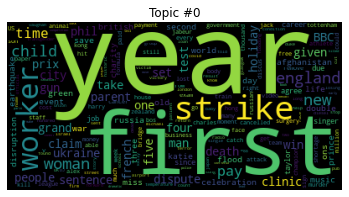

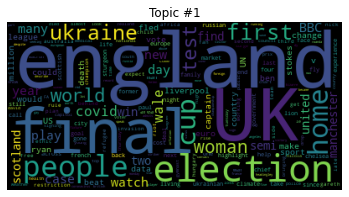

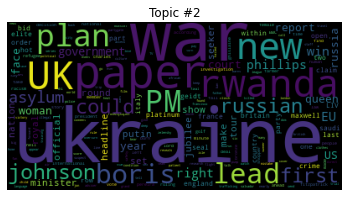

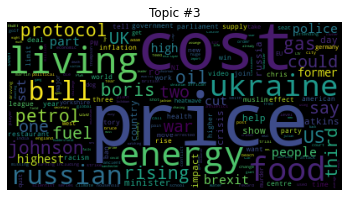

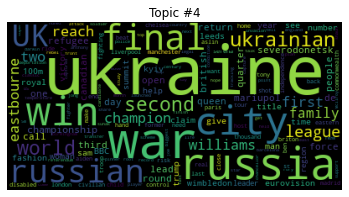

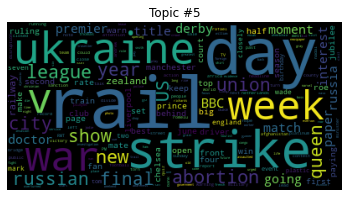

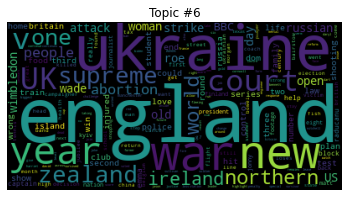

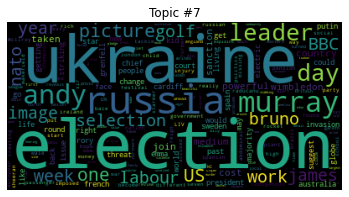

In [ ]:
#Clean paragraphs
Texts = []
for i in para_text:
  i = tokenize(i, 2) #Toggle 1 for stemmer and 2 for lemmatizer
  i = " ".join(i)
  i = i.replace('say ', '') #remove say which is very common
  Texts.append(i)

texts = [
    [word for word in document.split()]
    for document in Texts]

#making bigrams and trigrams with gensim
bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[texts], threshold=1)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]
texts_trigrams = [trigram_mod[doc] for doc in texts]

#manual way of switching model is to comment out this line
#texts=texts_trigrams

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]


dictionary = corpora.Dictionary(texts)
print(dictionary)

#run first
#dictionary.filter_extremes(no_below = 1, no_above=0.6)

#then run this way
dictionary.filter_extremes(no_below = 1.5, no_above=.8)
#should lead to similar dictionary size as above
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

#estimate the lda model by changing number of topics
topicnumber=8

#alpha default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics. In our case that is 0.5

lda=models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber)

lda.print_topics(topicnumber)


for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda, corpus, dictionary)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.035815  0.034312       1        1  14.739329
4     -0.060037 -0.070930       2        1  14.686604
6     -0.035588  0.007962       3        1  14.155376
2     -0.006082 -0.078796       4        1  13.783844
0     -0.076733  0.035711       5        1  11.875528
3      0.163876 -0.116410       6        1  10.841065
7      0.131418  0.159275       7        1   9.995176
5     -0.081038  0.028875       8        1   9.923078, topic_info=          Term        Freq       Total Category  logprob  loglift
2008      rail  149.000000  149.000000  Default  30.0000  30.0000
150      price  152.000000  152.000000  Default  29.0000  29.0000
9     election  197.000000  197.000000  Default  28.0000  28.0000
2041    strike  245.000000  245.000000  Default  27.0000  27.0000
42     england  461.000000  461.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
381         US   32.679044  266.187914   Topic8  -5.4923   0.2128
127        BBC   29.385157  229.544147   Topic8  -5.5986   0.2547
821      paper   27.310950  156.388581   Topic8  -5.6718   0.5653
916    zealand   27.002003  130.985992   Topic8  -5.6832   0.7311
108     russia   27.294144  323.858251   Topic8  -5.6724  -0.1633

[603 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1108      2  0.971451     100m
1108      5  0.031337     100m
3259      2  0.971808       5m
127       1  0.243962      BBC
127       2  0.117624      BBC
...     ...       ...      ...
916       3  0.458064  zealand
916       4  0.061075  zealand
916       5  0.114516  zealand
916       6  0.015269  zealand
916       8  0.206129  zealand

[1607 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 3, 1, 4, 8, 6])

[[(0, 0.013898798), (1, 0.9027177), (2, 0.013893406), (3, 0.01390155), (4, 0.013899101), (5, 0.013893874), (6, 0.013898749), (7, 0.013896808)], [(0, 0.010428666), (1, 0.81803775), (2, 0.010431469), (3, 0.010463155), (4, 0.010423589), (5, 0.010420817), (6, 0.11937206), (7, 0.010422484)], [(0, 0.008352298), (1, 0.008340337), (2, 0.17830096), (3, 0.008336337), (4, 0.008340312), (5, 0.45828265), (6, 0.008346321), (7, 0.32170075)], [(0, 0.007363229), (1, 0.94846904), (2, 0.0073608337), (3, 0.007357836), (4, 0.0073711644), (5, 0.00735481), (6, 0.0073669455), (7, 0.0073561342)], [(0, 0.011381605), (1, 0.9203503), (2, 0.01139938), (3, 0.011383528), (4, 0.011373651), (5, 0.011365906), (6, 0.0113734715), (7, 0.0113721285)], [(0, 0.0096245585), (1, 0.9326572), (2, 0.009619568), (3, 0.009621638), (4, 0.009618735), (5, 0.009618026), (6, 0.009622133), (7, 0.009618206)], [(0, 0.0069478843), (1, 0.36435115), (2, 0.0069489307), (3, 0.23345181), (4, 0.0069467914), (5, 0.006945736), (6, 0.367462), (7, 0.

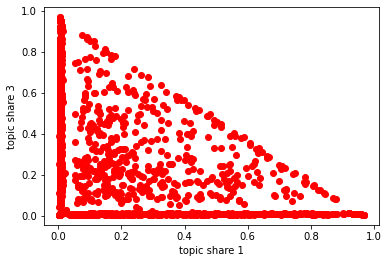

In [ ]:
get_document_topics = [lda.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#note you could also use this vector = [lda[item] for item in corpus] but it would not take into account the prior

#this produces a list of tuples
print(get_document_topics[0:10])

#getting only the topic shares out of the tuples
topic1share=[x[0][1] for x in get_document_topics]
topic2share=[x[1][1] for x in get_document_topics]
topic3share=[x[2][1] for x in get_document_topics]

#Inspect two topics
plt.scatter(topic1share,topic3share, color='r')
plt.xlabel('topic share 1')
plt.ylabel('topic share 3')
plt.show()